In [72]:
import numpy as np

In [73]:
pi = RR.pi()

def integrate_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    theta, x, y = var('θ, x, y')
    DE0 = kappa
    DE1 = cos(theta)
    DE2 = sin(theta)
    ICs = [srange[0], theta_0, x_0, y_0]

    P = desolve_system_rk4([DE0, DE1, DE2], [theta, x, y], ics=ICs, ivar=s, end_points=srange[1], step=step)
    return P


def splines_from_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    P = integrate_curvature(kappa, s, srange, theta_0, x_0, y_0, step)

    x_spline = spline([(s, x) for s, theta, x, y in P])
    y_spline = spline([(s, y) for s, theta, x, y in P])

    return (x_spline, y_spline)


def spline_avg(f):
    a = f.list()[0][0]
    b = f.list()[-1][0]
    return f.definite_integral(a, b) / (b - a)


def splines_to_angular_momentum(x_0, y_0, x_1, y_1, dt, srange=(0,1), center=(0,0)):
    def theta(a, b): return arccos(a.inner_product(b) / (a.norm() * b.norm()))
    def v_x(z): return (x_0(z) - x_1(z)) / dt
    def v_y(z): return (y_0(z) - y_1(z)) / dt
    def v(z): return vector([v_x(z), v_y(z)])
    def r(z): return sqrt((x_0(z) - center[0])^2 + (y_0(z) - center[1])^2)
    def w(z): return v(z).norm() * sin(theta(v(z), vector([x_0(z) - center[0], y_0(z) - center[1]]))) # |v| * sin(theta)
    integrand = lambda z: w(z) * r(z) # w * r
    angular_momentum = numerical_integral(integrand, srange[0], srange[1])[0] # int_S w * r^2 ds
    return angular_momentum


def splines_to_moment(x, y, srange=(0,1), center=(0,0)):
    return numerical_integral(lambda z: ((x(z) - center[0])^2 + (y(z) - center[1])^2), srange[0], srange[1])[0]


def translate_spline(f, dy):
    return spline([(x, y + dy) for x, y in f.list()])


def rotate_splines(x, y, theta):
    x_list = x.list()
    y_list = y.list()
    
    R = matrix([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    
    completed_x_list = [(s, x, y(s)) for s, x in x_list]
    completed_y_list = [(s, x(s), y) for s, y in y_list]
    
    rotated_x_spline = spline([(s, (R*vector([x, y]))[0]) for s, x, y in completed_x_list])
    rotated_y_spline = spline([(s, (R*vector([x, y]))[1]) for s, x, y in completed_y_list])
    
    return (rotated_x_spline, rotated_y_spline)


def splines_fix_center(x, y, center=(0,0)):
    x_bar = spline_avg(x)
    y_bar = spline_avg(y)
    return (translate_spline(x, -x_bar + center[0]), translate_spline(y, -y_bar + center[1]))

def splines_from_curvature_fix_center(kappa, s, srange=(0,1), theta_0=0, center=(0,0), step=0.1):
    x, y = splines_from_curvature(kappa, s, srange, theta_0, 0, 0, step)
    return splines_fix_center(x, y, center)


def flow_curvature(kappa, srange, arange, acount, theta_0=0, center=(0,0), step=0.1):
    splines = []
    rotated_splines = []
    space, dt = np.linspace(arange[0], arange[1], acount, retstep=True)
    total_counterrotation = 0
    curves = []
    for a in space:
        print(f"Calculating curve for a = {a}...")
        x, y = splines_from_curvature_fix_center(kappa(s, a), s, srange=srange, theta_0=theta_0, center=center, step=step)
        # print(x.list())
        # print(y.list())
        print("Done with curvature integration.")

        if len(splines) >= 1:
            print("Calculating angular momentum...")
            angular_momentum = splines_to_angular_momentum(splines[-1][0], splines[-1][1], x, y, dt, srange=srange, center=center)
            print("Done with angular momentum.")
            print("Calculating moment...")
            I = splines_to_moment(x, y, srange=srange, center=center)
            print("Done with moment.")
            print(f"I = {I}")
            angular_velocity = angular_momentum / I
            dtheta = angular_velocity * dt
            total_counterrotation += dtheta
            print(f"dtheta: {dtheta}\n")
            
        rotated_x, rotated_y = rotate_splines(x, y, total_counterrotation)
        rotated_translated_x, rotated_translated_y = splines_fix_center(rotated_x, rotated_y, center)
        rotated_splines.append((rotated_translated_x, rotated_translated_y))
        splines.append((x, y))
        
    return splines, rotated_splines

In [74]:
def metric_surf_rev_numerical(phi, psi):
    def g(u, v):
        X_u = vector([-phi(v)*sin(u), phi(v)*cos(u), 0])
        X_v = vector([phi.derivative(v)*cos(u), phi.derivative(v)*sin(u), psi.derivative(v)])
        E = X_u.dot_product(X_u)
        G = X_v.dot_product(X_v)
        return matrix([[E, 0], [0, G]])
    return g


def sample_metric_eigenvals(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    def angle(a, b):
        return arccos(a.inner_product(b) / (a.norm() * b.norm())) if a.norm() * b.norm() != 0 else 0
    
    squares = []
    transformed_squares = []
    ellipses = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        g_curr = g(u, v)
        eigenvectors = g_curr.eigenvectors_right()
        eigvec = eigenvectors[0][1][0]
        k1 = eigenvectors[0][0]
        if eigenvectors[0][2] == 2:
            k2 = k1
        else:
            k2 = eigenvectors[1][0]
        
        square = matrix([[0, -sq_len/2, 0, sq_len/2], [-sq_len/2, 0, sq_len/2, 0]])
        cross = vector([eigvec[0], eigvec[1], 0]).cross_product(vector([1, 0, 0]))
        theta = arctan2(cross[2], eigvec.dot_product(vector([1, 0])))
        R = matrix([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
        
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g_curr * R * square
        
        squares.append((R * square) + translate)
        transformed_squares.append(transformed + translate)
        ellipses.append((u, v, k1*sq_len/2, k2*sq_len/2, -theta))

    return squares, transformed_squares, ellipses

In [75]:
def curvature_surf_rev_numerical(phi):    
    def K(u, v):
        dphi = phi.derivative(v)
        d2phi = phi.derivative(v, order=2)
        dpsi = psi.derivative(v)
        d2psi = psi.derivative(v, order=2)
        
#         Go back to using formula with parametrization by arc length
        numerator = (-dpsi**2 * d2phi) + (dphi * dpsi * d2psi)
        denominator = phi(v) * (dphi**2 + dpsi**2)**2
        
        
        return numerator / denominator
    
    def k1(u, v):
        return 1 / phi(v)
    
    def k2(u, v):
        return K(u, v) / k1(u, v)
    
    return k1, k2, K

In [76]:
def reparametrize_by_arclength(x, y, *splines, t0=None, tf=None, dt=0.001, ds=0.1):
    if t0 is None:
        t0 = x.list()[0][0]
    if tf is None:
        tf = x.list()[-1][0]
        
    t_prev = t0 
    t = dt
    
    step_dist = 0
    total_dist = 0
    
    x_list = [(t0, x(t0))]
    y_list = [(t0, y(t0))]
    splines_lists = []
    for i in range(len(splines)):
        splines_list.append([])
    
    def reparametrize_step():
        x_list.append((total_dist, x(t)))
        y_list.append((total_dist, y(t)))
        for i, spline_list in enumerate(splines_lists):
            spline_list.append((total_dist, splines[i](t)))
    
    while t <= tf:
        x_diff = x(t) - x(t_prev)
        y_diff = y(t) - y(t_prev)
        
        dist = sqrt(x_diff**2 + y_diff**2)
        step_dist += dist
        total_dist += dist
        
        if step_dist >= ds:
            reparametrize_step()
            step_dist = 0
        
        t_prev = t
        t += dt
    
    if total_dist > x.list()[-1][0]:
        t = t_prev
        reparametrize_step()
    
    new_x_spline = spline(x_list)
    new_y_spline = spline(y_list)
    new_splines = map(lambda spline_list: spline(spline_list), splines_lists)
    
    if len(splines_lists) > 0:
        return new_x_spline, new_y_spline, new_splines
    else:
        return new_x_spline, new_y_spline

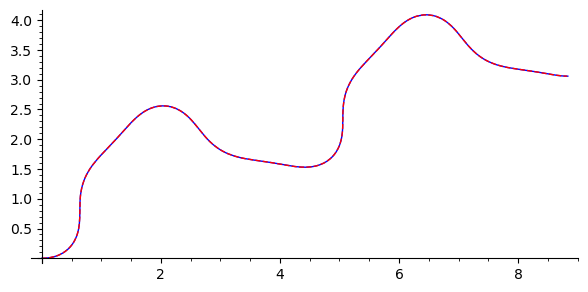

In [85]:
# x = spline([(0, 1), (1, 2), (4, 5), (5, 3)])
# y = spline([(0, 2), (1, 4), (4, 5), (5, 3)])
srange=(0, 4*RR.pi())
kappa(s) = sin(3*s)+cos(s)
x, y = splines_from_curvature(kappa, s, srange, step=0.01)
xs, ys = reparametrize_by_arclength(x, y, ds=0.02)
plot1 = parametric_plot((x, y), srange, color='blue')
plot2 = parametric_plot((xs, ys), (xs.list()[0][0], xs.list()[-1][0]), color='red', linestyle='--')
show(plot1 + plot2)

In [297]:
def xy_splines_from_hm(h, m, srange=(0, pi), step_size=0.1):
    def y(rho):
        return sqrt(m(rho))
    
    rho_space = np.linspace(srange[0], srange[1], round((srange[1] - srange[0]) / step_size))
    y_spline = spline([(rho, y(rho)) for rho in rho_space])
    
    def x(rho):
        return numerical_integral(lambda s: sqrt(h(s) - (y_spline.derivative(s))**2), 0.01, rho)[0]
    
    x_spline = spline([(rho, x(rho)) for rho in rho_space])
    
    return x_spline, y_spline

In [298]:
def to_spline(f, srange=(0, pi), step_size=0.01):
    return spline([(s, f(s)) for s in np.linspace(srange[0], srange[1], round((srange[1] - srange[0]) / step_size))])

In [299]:
c3 = 3
c5 = 5
h(rho) = 1
m(rho) = ((sin(rho) + c3*sin(3*rho) + c5*sin(5*rho))/(1 + 3*c3 + 5*c5))**2

In [300]:
srange=(0.01, pi-0.01)
h = to_spline(h, srange)
m = to_spline(m, srange)


In [301]:
x, y = xy_splines_from_hm(h, m, srange)
print(x.list())

[(0.01, 0.0), (0.11405308845299311, 0.029096804231788165), (0.21810617690598624, 0.09888597145807905), (0.3221592653589794, 0.1951137007476987), (0.4262123538119725, 0.29806027407579694), (0.5302654422649656, 0.39014711439170646), (0.6343185307179587, 0.4617748813476227), (0.7383716191709518, 0.5162258664902115), (0.842424707623945, 0.6077603448913568), (0.946477796076938, 0.7031737008541771), (1.0505308845299313, 0.8067431977856387), (1.1545839729829244, 0.9063826110752979), (1.2586370614359175, 0.9979744007177274), (1.3626901498889106, 1.100094830379574), (1.4667432383419037, 1.196042277348862), (1.5707963267948968, 1.2985792108409322), (1.6748494152478899, 1.4011162059545355), (1.778902503700883, 1.4970636330465357), (1.882955592153876, 1.5991840886218864), (1.9870086806068692, 1.690775896630012), (2.0910617690598623, 1.790415266886343), (2.195114857512855, 1.8939847996123085), (2.2991679459658485, 1.9893981279778175), (2.4032210344188414, 2.080932641486916), (2.5072741228718347, 2.

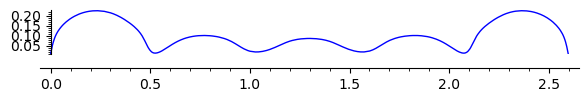

In [302]:
parametric_plot((x, y), (x.list()[0][0], x.list()[-1][0]))

In [307]:
def K(y, rho):
    return y.derivative(rho, order=2)/y(rho)   

dt=0.00001
h_ = spline([(rho, h_rho_ - 2*K(y, rho)*dt) for rho, h_rho_ in h.list()])
m_ = spline([(rho, m_rho_ - 2*K(y, rho)*dt) for rho, m_rho_ in m.list()])
print(m_.list())
x, y = xy_splines_from_hm(h_, m_, srange)

[(0.01, 9.993268578613436e-05), (0.020037275413472007, 0.0006213517165183282), (0.030074550826944012, 0.0011939895726799485), (0.04011182624041602, 0.001924092230117398), (0.05014910165388802, 0.0028281632106980253), (0.060186377067360027, 0.003906437097294649), (0.07022365248083202, 0.005153465926953214), (0.08026092789430403, 0.006560828210781253), (0.09029820330777603, 0.008118093777433135), (0.10033547872124804, 0.00981327239293435), (0.11037275413472004, 0.011633080716692007), (0.12041002954819205, 0.013554171395471853), (0.13044730496166407, 0.015566588558062767), (0.14048458037513606, 0.017659379243780218), (0.15052185578860808, 0.019815477747299463), (0.1605591312020801, 0.022017435166075496), (0.1705964066155521, 0.024247544386614098), (0.18063368202902408, 0.02648797400104678), (0.1906709574424961, 0.02872090730441233), (0.20070823285596812, 0.030928683547031714), (0.2107455082694401, 0.03309393920885545), (0.2207827836829121, 0.03519708959340824), (0.23082005909638412, 0.037

ValueError: math domain error

In [ ]:
def K(y, rho):
    return y.derivative(rho, order=2)/y(rho)

steps = 100
t_space, dt = np.linspace(0, 1, steps, retstep=True)
plots = []
for t in t_space:
    h = spline([(rho, h_rho_ - 2*K(y, rho)*dt) for rho, h_rho_ in h.list()])
    m = spline([(rho, m_rho_ - 2*K(y, rho)*dt) for rho, m_rho_ in m.list()])
    print(h.list())
    x, y = xy_splines_from_hm(h, m, srange)
    plots.append([parametric_plot((x, y), (y.list()[0][0], y.list()[-1][0]))])
    
a = animate(plots)
a.show()